# Learning to play Blackjack with Monte Carlo methods

https://en.wikipedia.org/wiki/Blackjack

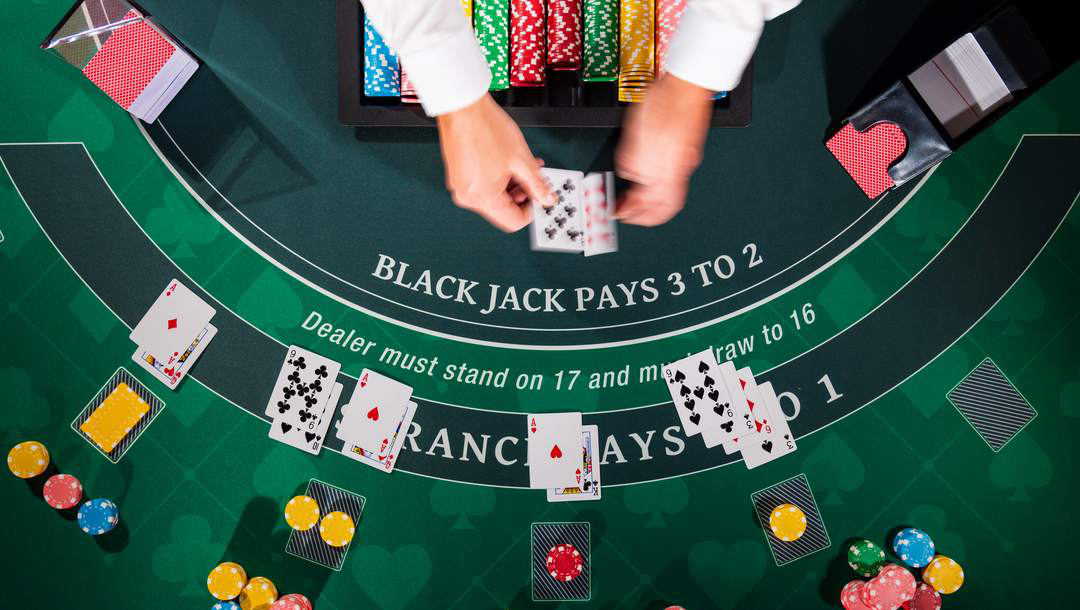

## Setting up the environment

https://gymnasium.farama.org/environments/toy_text/blackjack/

In [1]:
import gymnasium as gym
import numpy as np
from collections import defaultdict
from typing import Tuple, Sequence, Callable
import copy
import pickle

# visualization methods 
import blackjack_plots

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import copy
from matplotlib import cm

In [3]:
env = gym.make('Blackjack-v1') # create blackjack environment

In [4]:
env.action_space # number of actions available (0 "stay" or 1 "hit")

Discrete(2)

In [5]:
env.observation_space # the state space is comprised of (total_player, visible_card_dealer, Whether or not I have an Ace)
                      # total player is in the range [4 - 32]
                      # visible_card_dealer in range [1 - 11]
                      # Whether or not I have a usable ace: True/False

Tuple(Discrete(32), Discrete(11), Discrete(2))

In [6]:
PlayerTotal = int
DealerCard = int
UsableAce = bool

State = (PlayerTotal, DealerCard, UsableAce)

## Example Interacting with the env 

Reset the environment and get the first state (player sum, dealer card showing, Usable Ace?)

In [7]:
env.reset() #reset the environment, get the first state

((21, 1, True), {})

Take an action, e.g. hit = 1 and see the resulting next state

In [8]:
action = 1 # hit
env.step(action) # returns ((current state), reward, termination, truncation, info) 

((15, 1, False), 0.0, False, False, {})

# Define a policy $\pi$

- $\pi$ maps states to actions S -> A. 


- Here state is a tuple: $(PlayerScore, DealerCardShowing, UsableAce)$ and our actions are $\{0,1\}$

- Assign to each possible state a probablity distribution over actions (either 0 or 1) 

$$
P(Action = 0|PlayerScore, DealerScore, AceShowing)
$$
and 
$$
P(Action = 1|PlayerScore, DealerScore, AceShowing)
$$


In [9]:
ActionProb = np.ndarray[float, float]

In [10]:
def random_policy(player_total: PlayerTotal, deal_card_showing: DealerCard, ace: UsableAce) -> ActionProb:
    ''' sampling an action at random '''
    return np.ones(2) * 0.5


In [11]:
def naive_policy(player_total: PlayerTotal, deal_card_showing: DealerCard, ace: UsableAce) -> ActionProb:
    ''' an implementation of a niave policy '''
 
    # if I have more than 18 "stay" with high probability
    if player_total < 18:
        return np.array([0.1, 0.9]) 
    
    # otherwise "hit" with high probability
    else:
        return np.array([0.9, 0.1])
        

In [12]:
''' Create your own policy and see how good it performs! '''
def my_policy(player_total: PlayerTotal, deal_card_showing: DealerCard, ace: UsableAce) -> ActionProb:
    pass

In [ ]:
pl

# Example of running a policy in the environment

In [19]:
next_state = env.reset()[0]
actions = [0, 1]
print(f"**Start of Game with state: {next_state} \n")

game_over = False
while not game_over:
    
    player_total, dealer_card, usable_ace = next_state
    
    # take an action with random probability
    action = np.random.choice(actions, 1, p = random_policy(player_total, dealer_card, usable_ace))[0]
    print(f"Taking action: {'Stay' if not action else 'Hit'}")
    
    # transition
    next_state, reward, game_over, _, _ = env.step(action)
    print(f"Transitioning to state: {(next_state)} with reward: {reward}")

**Start of Game with state: (13, 4, False) 

Taking action: Hit
Transitioning to state: (19, 4, False) with reward: 0.0
Taking action: Stay
Transitioning to state: (19, 4, False) with reward: -1.0


In [20]:
Action = int
Reward = int

Episode = list[State, Action, Reward]

In [21]:
def generate_episode(policy:Callable) -> Episode:
    '''
    Function to generate an episode following a policy
    '''
    
    episode = [] # store the episode
    state = env.reset()[0] # start the game
    
    game_over = False
    while not game_over:
        
        # get action
        action = np.random.choice(actions, 1, p = policy(*state))[0]

        # take action in environement
        next_state, reward, game_over, _, _ = env.step(action)

        # append outcome
        episode.append((state, action, reward))
        
        state = next_state
    
    return episode

In [22]:
def generate_episodes(policy:Callable, num_episodes: int) -> list[Episode]:
    '''Generate multiple episodes'''
    
    episodes = []

    counter = 0
    while counter < num_episodes:
        episodes.append(generate_episode(policy))
        counter +=1
        
    return episodes

In [23]:
# example of generating a random episode
generate_episode(random_policy)

[((14, 7, False), 1, -1.0)]

In [24]:
# example of generating an episode following a naive policy
generate_episode(naive_policy)

[((19, 8, False), 0, 1.0)]

In [26]:
random_policy_np = blackjack_plots.change_policy_to_np_array(random_policy)

In [27]:
naive_policy_np = blackjack_plots.change_policy_to_np_array(naive_policy)

In [28]:
naive_policy_np[1,1,1], random_policy_np[1,1,1]

(array([0.1, 0.9]), array([0.5, 0.5]))

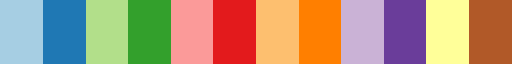

In [29]:
cm.get_cmap("Paired")

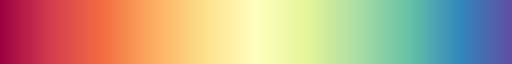

In [30]:
cm.get_cmap("Spectral")

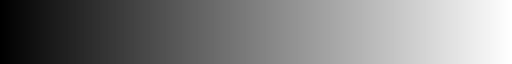

In [31]:
cm.gray

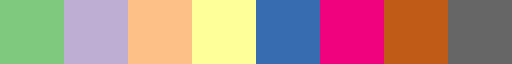

In [32]:
cm.Accent

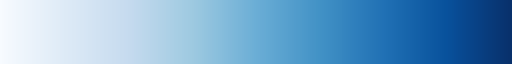

In [33]:
cm.Blues

In [34]:
random_policy_np[:,:,0][1,1,1]

0.5

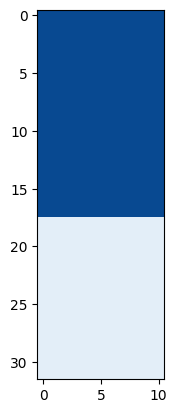

In [35]:
plt.imshow(
    naive_policy_np[:,:,0][:,:,1], 
    cmap=cm.Blues,
    vmin=0,
    vmax=1
)

In [36]:
colors = [cm.get_cmap("Paired")(0.1), cm.get_cmap("Paired")(0.7)]
label = ['Hit', 'Stay']

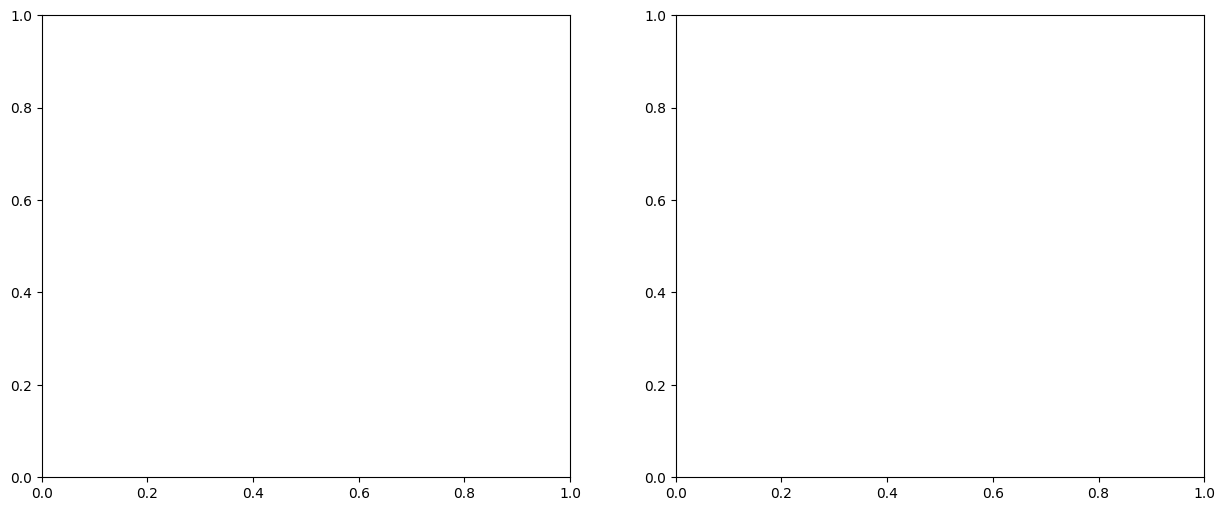

In [37]:
fig, axs = plt.subplots(1, 2, figsize = (15,6))

In [38]:
np.arange(22,11, -1)

array([22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12])

In [45]:
naive_policy_np[10:22,1:11,0].shape

(12, 10, 2)

In [70]:
naive_policy_np[10:22,1:11,0][:,:,1]

array([[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9],
       [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9],
       [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9],
       [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9],
       [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9],
       [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9],
       [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9],
       [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]])

In [88]:
def plot_policy(policy:np.ndarray):
    
    fig, axs, = plt.subplots(1, 2, figsize = (15, 6))
    
    extent = -1, 9, -1, 11  # the x tick limits 
    x_range = np.arange(10)
    
    # first plot
    surf = axs[0].imshow(
        np.flip(policy[10:22,1:11,0][:,:,1]),  # flip so that low player card is at the bottom not top
        cmap=cm.Blues,
        vmin=0,
        vmax=1,
        interpolation='nearest',
        extent=extent
    )

    plt.sca(axs[0])  # set current axis
    plt.xticks(x_range, ('A', '2', '3', '4', '5', '6', '7', '8', '9', '10'))
    plt.yticks(np.arange(12), (str(i) for i in range(10, 22, 1)))
    axs[0].set_xlabel('Dealer Card Showing')
    axs[0].set_ylabel('Player Total')
    axs[0].set_title("Policy ($\pi$) Without Ace")
    axs[0].grid()

    col_bar = fig.colorbar(surf, ax=axs[0])
    col_bar.set_ticks([0,0.5, 1])
    col_bar.set_ticklabels(['Stay (0)', 'Random (0.5)', 'Hit (1)'])
    col_bar.ax.invert_yaxis()  # flip the y axis
    
    # second plot
    surf = axs[1].imshow(
        np.flip(policy[10:22,1:11,1][:,:,1]),  # flip so that low player card is at the bottom not top
        cmap=cm.Blues,
        vmin=0,
        vmax=1,
        interpolation='nearest',
        extent=extent
    )
    
    

    plt.sca(axs[1])  # set current axis
    plt.xticks(x_range, ('A', '2', '3', '4', '5', '6', '7', '8', '9', '10'))
    plt.yticks(np.arange(12), (str(i) for i in range(10, 22, 1)))
    axs[1].set_xlabel('Dealer Card Showing')
    axs[1].set_ylabel('Player Total')
    axs[1].set_title("Policy ($\pi$) With Ace")
    axs[1].grid()

    col_bar = fig.colorbar(surf, ax=axs[1])
    col_bar.set_ticks([0,0.5, 1])
    col_bar.set_ticklabels(['Stay (0)', 'Random (0.5)', 'Hit (1)'])
    col_bar.ax.invert_yaxis()  # flip the y axis
    
    plt.show()

In [91]:
type(random_policy_np) == np.ndarray

True

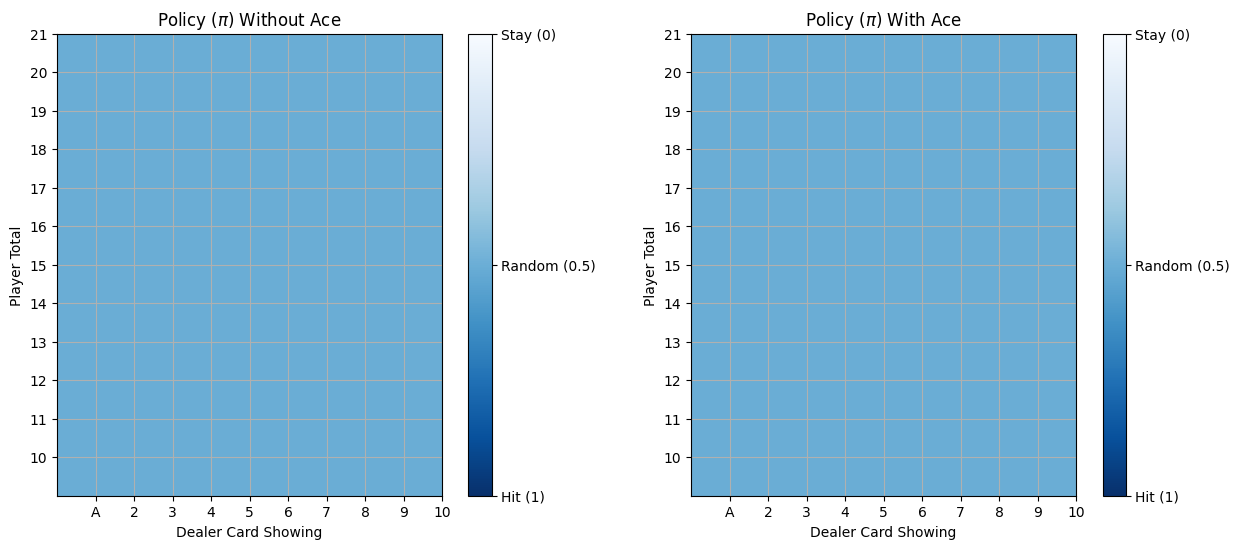

In [89]:
plot_policy(random_`policy_np)

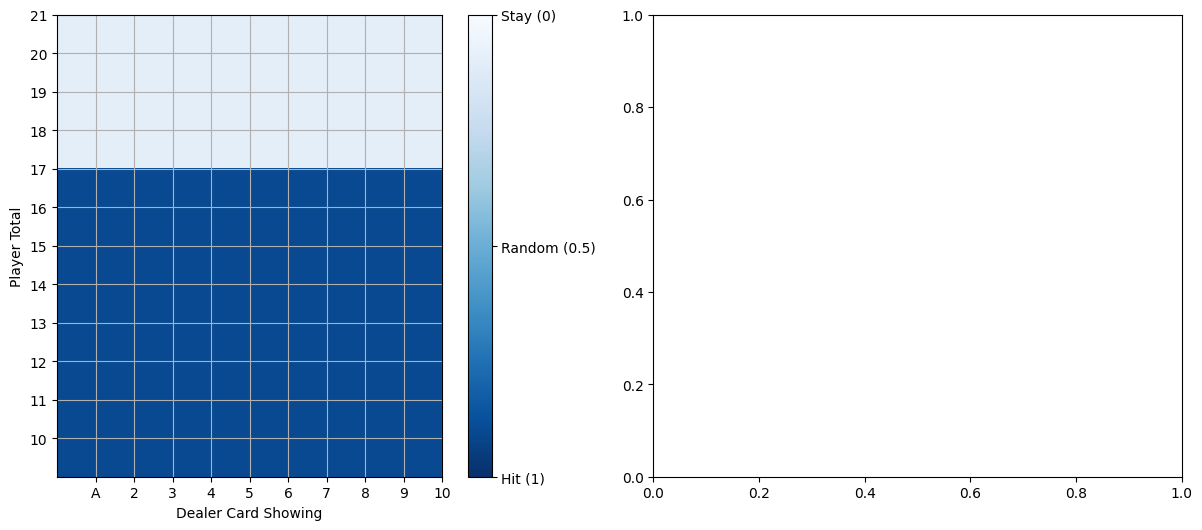

In [67]:
fig, axs = plt.subplots(1, 2, figsize = (15,6))

extent = -1, 9, 0, 11
surf = axs[0].imshow(
    np.flip(naive_policy_np[10:22,1:11,0][:,:,1]), 
    cmap=cm.Blues,
    vmin=0,
    vmax=1,
    interpolation='nearest',
    extent=extent
)



# axs[0].set_xticklabels(np.arange(21, 10, -1))

In [128]:
fig.colorbar(surf)

In [126]:
plt.show()

In [58]:
player_range = np.arange(11, 22)
dealer_range = np.arange(1, 11)



In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import copy
from matplotlib import cm

In [108]:
acdx = ppp[10:22,1:12,0]

In [109]:
acdx.shape

(12, 10, 2)

In [112]:
surf = ax_no_ace.imshow(acdx[:,:,1], cmap = plt.cm.gray)
plt.show()

In [37]:
acdx[:,:,0].shape

(12, 10)

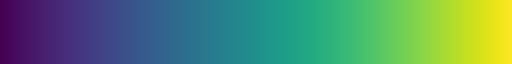

In [64]:
plt.cm.viridis

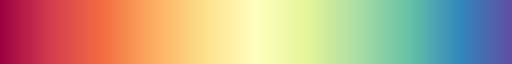

In [57]:
plt.get_cmap('Spectral')

In [58]:
surf = ax_no_ace.imshow(acdx[:,:,0], cmap = plt.get_cmap('Spectral'))

In [59]:
plt.show()

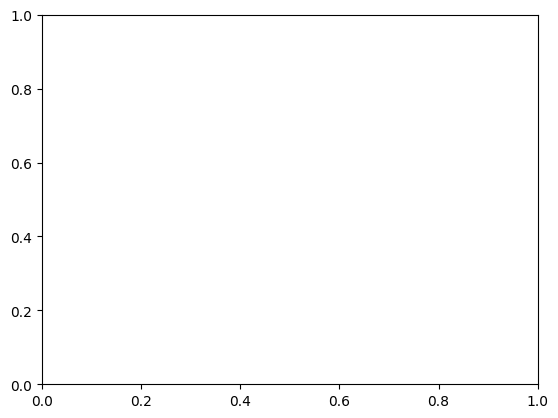

In [60]:
plt.colorbar(surf, ticks= [0,1])

In [46]:
plt.show()

In [60]:
dealer_range, player_range`

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]))

In [61]:
ax_no_ace.pcolor(dealer_range, player_range, ppp[:,:,0])

ValueError: too many values to unpack (expected 2)

ValueError: too many values to unpack (expected 2)

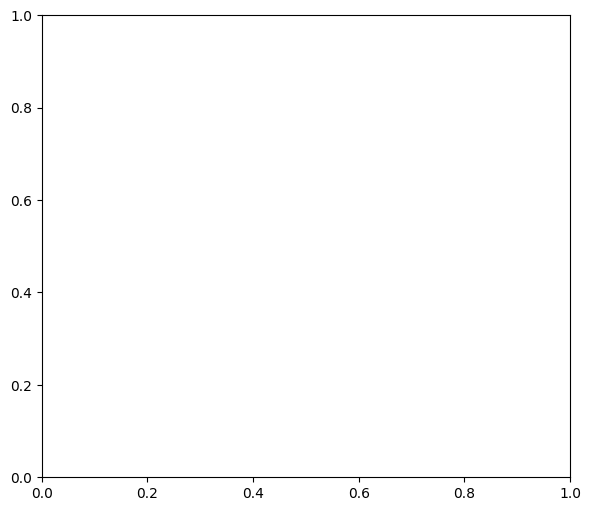

In [43]:
# visualizing the policy
blackjack_plots.plot_policy(naive_policy)

In [30]:
# generate multiple episodes
episodes = generate_episodes(naive_policy, 1_000)

In [31]:
episodes[:10]

[[((19, 10, False), 0, 1.0)],
 [((20, 10, False), 0, 1.0)],
 [((19, 10, False), 0, -1.0)],
 [((20, 3, False), 0, 1.0)],
 [((13, 2, False), 1, -1.0)],
 [((19, 10, True), 0, -1.0)],
 [((18, 2, False), 1, -1.0)],
 [((20, 10, False), 0, 1.0)],
 [((14, 9, False), 1, 0.0), ((19, 9, False), 0, 0.0)],
 [((16, 7, False), 1, -1.0)]]

## Monte Carlo Estimation

In [32]:
def get_return(episode, indx = 0, discount = 1.0):
    '''
    Function to get the discounted return of an episode
    '''
    
    total = 0
    
    for i in range(indx, len(episode)):
        state, action, reward = episode[i]
        
        total += (discount ** i) * reward

    return total

In [33]:
def mc_estimation(episodes, discount = 1.0):
    '''
    Implementation of first visit Monte Carlo estimation 
    '''
    
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for episode in episodes:
        
        visited_states = set()
        index = 0
        
        for step in episode:
            
            state, action, reward = step
            
            if (state not in visited_states):
                
                visited_states.add(state)
                
                r = get_return(episode[index:], discount = discount)
                returns_sum[state][action] += r
                N[state][action] += 1.0
                Q[state][action] = returns_sum[state][action] / N[state][action]
                
            index += 1
            
    return Q

In [87]:
naive_episodes = generate_episodes(naive_policy, 100_000)
rand_episodes = generate_episodes(random_policy, 100_000)

In [88]:
rand_episodes[:10]

[[((11, 2, False), 0, -1.0)],
 [((10, 10, False), 1, 0.0),
  ((12, 10, False), 1, 0.0),
  ((15, 10, False), 1, 0.0),
  ((18, 10, False), 0, -1.0)],
 [((14, 5, False), 1, -1.0)],
 [((17, 10, False), 1, -1.0)],
 [((5, 10, False), 1, 0.0), ((8, 10, False), 0, -1.0)],
 [((20, 9, False), 0, 1.0)],
 [((10, 10, False), 0, -1.0)],
 [((9, 1, False), 0, -1.0)],
 [((15, 1, False), 0, -1.0)],
 [((8, 7, False), 1, 0.0), ((13, 7, False), 1, 0.0), ((21, 7, False), 0, 1.0)]]

In [86]:
with open("./data/naive_episodes.pickle", 'rb') as f:
    naive_episodes = pickle.load(f)

In [23]:
with open("./data/rand_episodes.pickle", 'rb') as f:
    rand_episodes = pickle.load(f)

In [89]:
naive_Q = mc_estimation(naive_episodes)
rand_Q = mc_estimation(rand_episodes)

In [90]:
def Q_to_V(Q:dict, policy: Callable) -> dict:
    '''
    Function to change Q values into V values
    '''
    v={}
    for state, value in Q.items():
        v[state] = np.dot(policy(*state), value)
    
    return v

In [91]:
naive_v = Q_to_V(naive_Q, naive_policy)
rand_v = Q_to_V(rand_Q, random_policy)

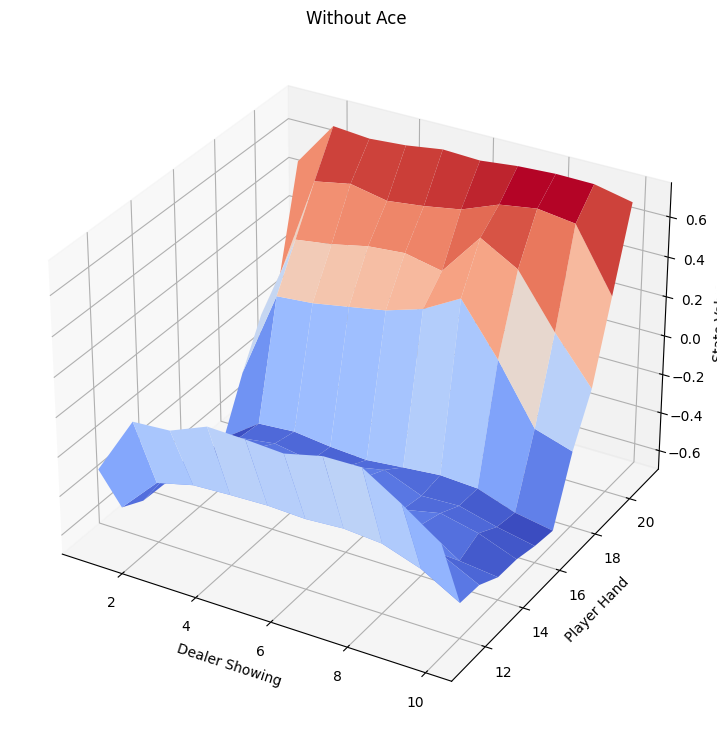

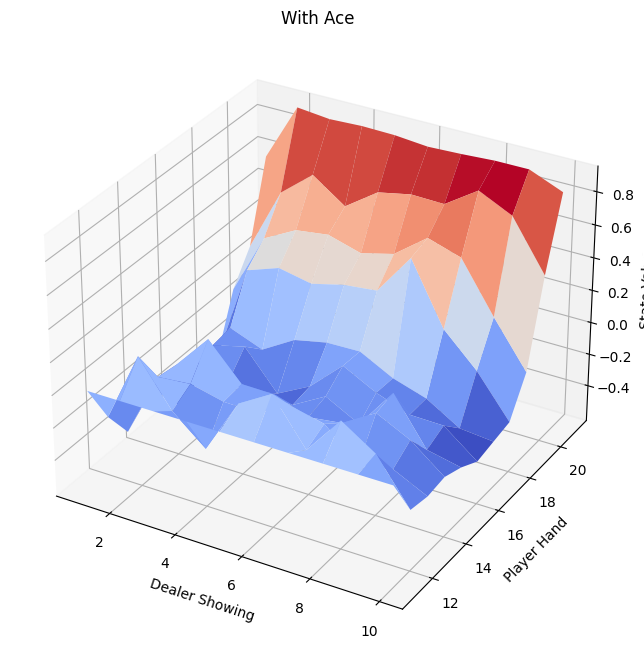

In [92]:
blackjack_plots.plot_values(naive_v)

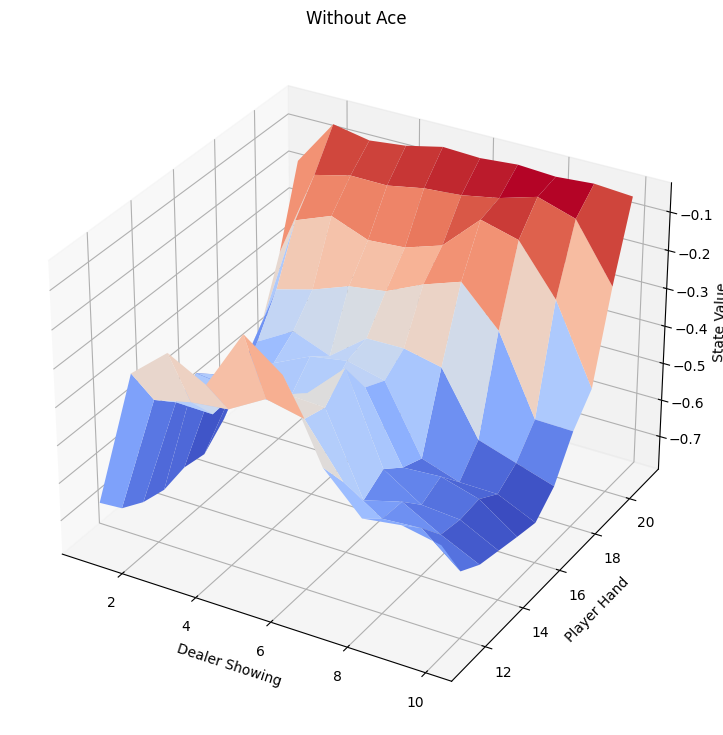

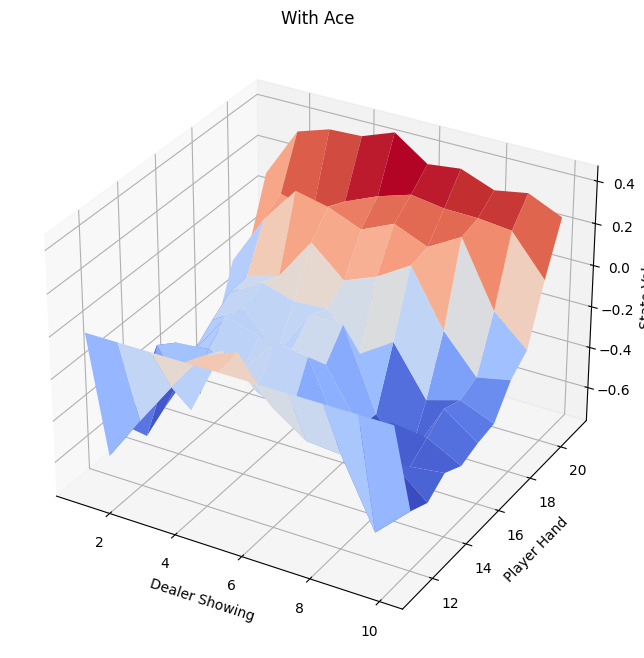

In [93]:
blackjack_plots.plot_values(rand_v)

# Monte Carlo Control

In [80]:
def update_explore_rate(t):
    '''Decay explore_rate over time'''
    return max(0.1, min(1, 1.0 - np.log10((t + 1) / 10e3)))

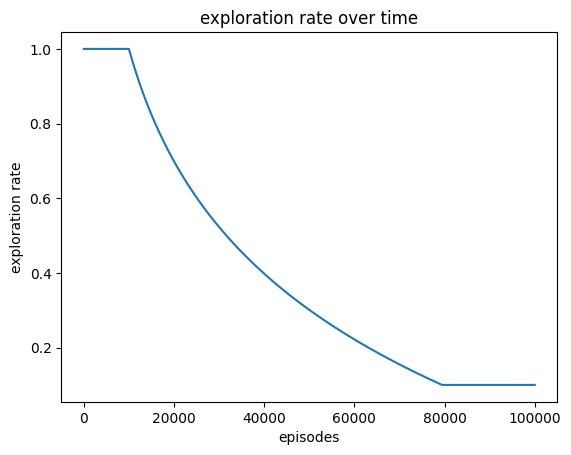

In [81]:
# Visualizing this decay
import matplotlib.pyplot as plt

t = np.arange(0, 100_000, 10)
y = []
for i in t:
    y.append(update_explore_rate(i))

plt.plot(t, y)
plt.xlabel("episodes")
plt.ylabel("exploration rate")
plt.title("exploration rate over time")
plt.show()

In [53]:
def mc_control(policy, explore_rate, number_iterations, discount = 1.0):
    
    new_policy = policy.copy()
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    
    
    counter = 0
    while counter < number_iterations:
        counter +=1
        
        # create decaying learning rate 
        epsilon = explore_rate(counter)
            
        episode = generate_episode(new_policy)
        visited_states = []
        index = 0

        for step in episode:

            state, action, reward = step

            if (state not in visited_states):

                visited_states.append(state)
                r = get_return(episode[index:],discount = discount)
                returns_sum[state][action] += r
                N[state][action] += 1.0
                Q[state][action] = returns_sum[state][action] / N[state][action]
        
        for state in visited_states:
            
            a_star = np.argmax(Q[state])
            a_other = 1 - a_star

            # update policy
            new_policy[state][a_star] = 1 -  epsilon/2
            new_policy[state][a_other] = epsilon/2


            index += 1
            
    return Q, new_policy

In [54]:
new_Q, new_policy = mc_control(naive_policy, explore_rate=update_explore_rate, number_iterations = 500_000)

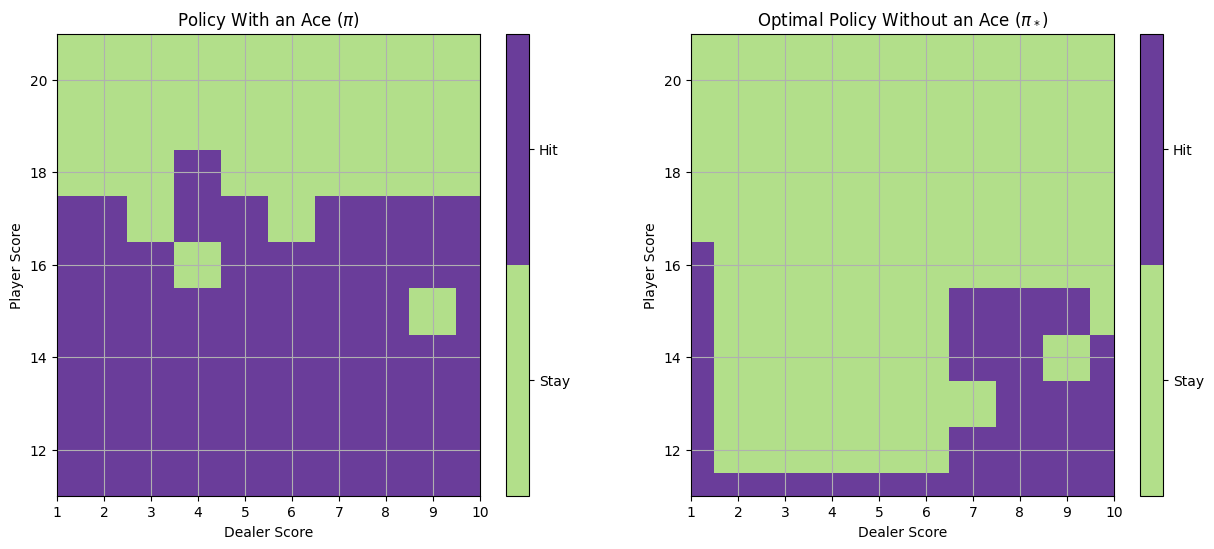

In [55]:
plot_policy(new_policy)

In [57]:
print(new_policy[(13, 2, True)])

[0.05, 0.95]


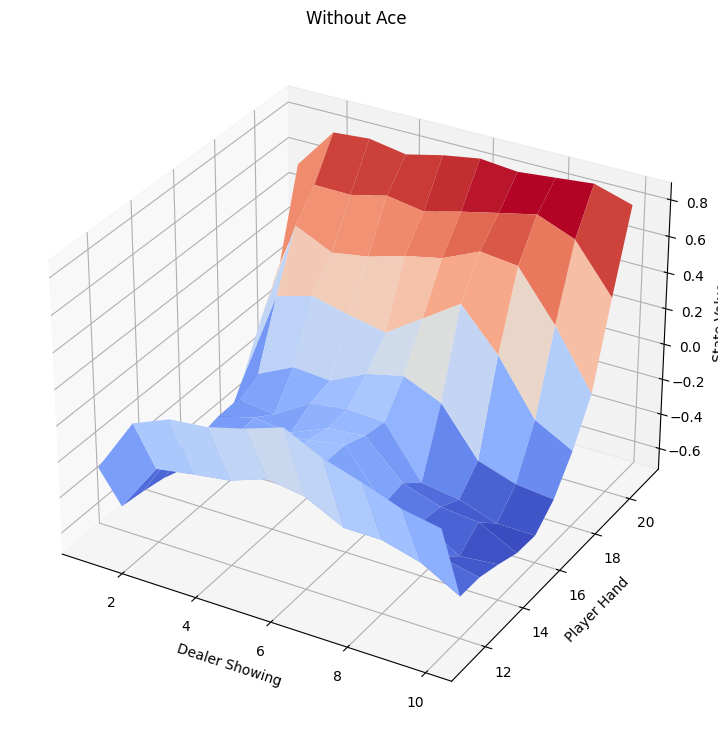

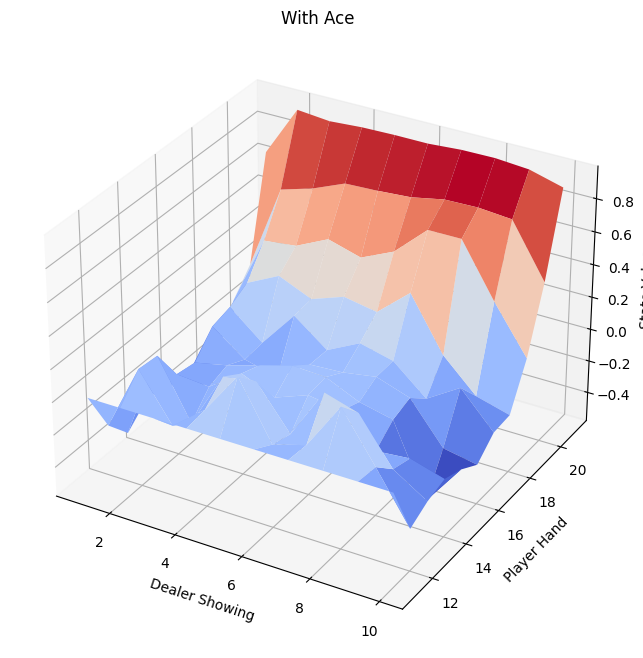

In [58]:
# Generate new episodes
opt_episodes = generate_episodes(new_policy, 100_000)

opt_Q = mc_estimation(opt_episodes)
opt_V = Q_to_V(opt_Q, new_policy)

plot_values(opt_V)

In [61]:
def average_return(episodes):
    
    returns = []
    for episode in episodes:
        
        r = get_return(episode)
        returns.append(r)
    
    returns = np.array(returns)
        
    return f"{np.mean(returns)} +- {np.std(returns)}"

In [62]:
print(average_return(naive_episodes))
print(average_return(opt_episodes))
print(average_return(rand_episodes))

-0.178999 +- 0.9440467986275892
-0.08721 +- 0.9562135827836792
-0.392596 +- 0.8970252955095525
